In [39]:
import os

os.chdir('/Users/wang/Desktop/8. Literature Light Map/3. sythetic control')

In [40]:
import pandas as pd
import numpy as np
from src.synth import Synth

import seaborn as sns
import matplotlib.pyplot as plt

### 1. Synthetic control with California Proposition 99 Example

In [41]:
data = pd.read_stata("data/prop99_example.dta")

In [42]:
# build the model
model = Synth()

# fit the data
fit = model.fit(data, outcome='packspercapita', time='year', id='state', treated='treated')

# predict the sythethic control
fitted = fit.predict()

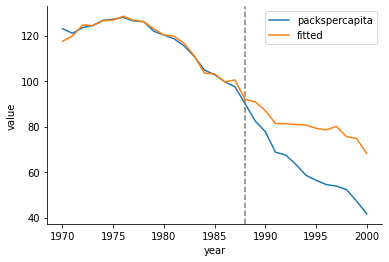

In [43]:
# plot
dat = data.query("state=='California'").copy()
dat['fitted'] = fitted
temp = dat[['packspercapita', 'year', 'fitted']].melt('year')
sns.lineplot(temp, x='year', y='value', hue='variable')
plt.legend(title=None)
plt.axvline(x=1988, linestyle='--', color='gray')
sns.despine()

### 2. Hypothesis test

For the post treatment period, the trajectory of estimated treatement effect is given by $\theta = (\theta_{T0+1}, \cdots, \theta_T)$

$$
H_0: \theta = \theta^0
$$

So this hypothesis fully determines the counterfactual outcome in the absence of treatment:

\begin{align*}
Y^{null}_{t}(0) &= Y_t(1) - \theta_t^0, \quad for \quad t \in (T_0 + 1, \cdots, T) \\
Y^{null}_{t}(0) &= Y_t(0), \quad for \quad t \in (1, \cdots, T_0)
\end{align*}


Following the null hypothesis, we generate the data and the test the residul of the generate data to the estimated counterfactual data by synthetic control. 
$$
\mu_t = Y^{null}_t(0) - Y_t^{syn}(0), \quad for \quad t \in (1, \cdots, T)
$$

If the residuals are too extreme, we say that the treatment is unlikely the effect on the treated based the null hypothesis we’ve assumed.

In [8]:
def with_effect(df, null_hypothesis=0, start_at=1989, target_year=2000):
    dat = df[df.state=='California'].copy()
    window_mask = (dat.year >= start_at) & (dat.year <= target_year)
    
    y = np.where(window_mask, dat['packspercapita'] - null_hypothesis, dat['packspercapita'])
    dat = dat.assign(**{'null': y})
    
    return dat[dat.year<=target_year]

+ 1. First, we assume the null treatment effect is -4, that is without the treatment the counterfactual packs of ciggarettes per capita will be 4 packs higher, as presented by the blue line.

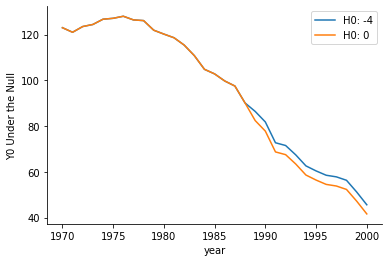

In [9]:
dat = with_effect(data, -4, 1989, 2000)
sns.lineplot(dat, x='year', y='null', label="H0: -4")
sns.lineplot(dat, x='year', y='packspercapita', label="H0: 0")

plt.ylabel("Y0 Under the Null")
plt.legend()
sns.despine()

+ 2. We fit the model for counterfactual $Y(0)$ pre- and post-treatment period. 

The idea here is that the model must be estimated with the entire data, under the postulated null hypothesis, to avoid huge post intervention residuals. With this model, we then compute the residuals $\hat{\mu}_t = Y_t^{null}(0) - \hat{Y}_t(0) $ for all time periods.

In [46]:
# build the model
model = Synth()

# fit the data
fit = model.fit(data, outcome='packspercapita', time='year', id='state', treated='treated')

# predict the sythethic control
fitted = fit.predict()

# build the null hypothesis, the null is treatment effect is 0
dat = with_effect(data, 0, 1989, 2000)

# add fitted values
dat['syn'] = fitted[range(len(dat))]

# compute residuals
dat['residual'] = dat.null - dat.syn

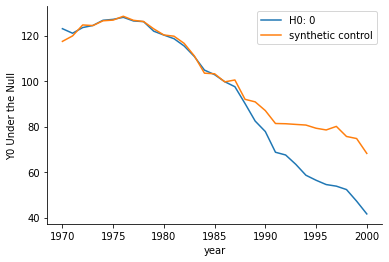

In [47]:
sns.lineplot(dat, x='year', y='null', label="H0: 0")
sns.lineplot(dat, x='year', y='syn', label="synthetic control")

plt.ylabel("Y0 Under the Null")
plt.legend()
sns.despine()

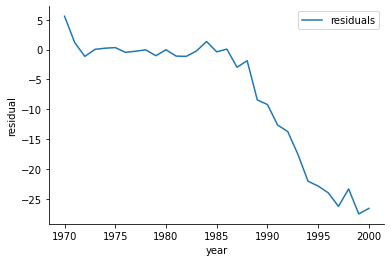

In [48]:
sns.lineplot(dat, x='year', y='residual', label="residuals")

plt.legend()
sns.despine()

We can already see that the model fitted under $H_0:0 $ yields quite large and negative residuals, which is some evidence we might want to reject this null of no effect.

### 3. Test statistics

The test statistics S summarizes how big are the residuals and hence, how unikly is the data we saw, under the null.

$$
S(\hat{u})_q = \left(\sum_{t=T_0+1}^{T} |u_t|^q \right)^{1/q}
$$

for the moment we focus on $q=1$, i.e $S(\hat{u}) = \sum_{t=T_0+1}^{T} |u_t| $. Notice that this statistic is computed using only the post-intervention period, with $t \geq T_0 + 1 $.


In [49]:
# test statistics
def test_statistic(u_hat, q=1, axis=0):
    return (np.abs(u_hat) ** q).sum(axis=axis) ** (1/q)

In [50]:
print("H0:0 ", test_statistic(u_hat=dat.query("treated==1")["residual"], q=1, axis=0))

H0:0  234.17179179300766


+ High values of this test statistic indicate poor post intervention fit and, hence rejection of the null. However, we could have pretty big test statistics in the post-intervention period if our model is poorly fitted, even if $H_0$ is true.

+ This means we can’t define high in absolute terms. Rather, we have to think about how high are the post intervention residuals - and test statistics - in comparison to the pre-intervention residuals.

### 4. P-value

+ To compute the P-value, we block-permute the residuals, calculating the test statistic in each permutation.

+ Notice, we permute with all the residuls including pre- and post-treatment priods, however we compute the test statistics only with the post-treatment periods.

+ Once we do that, we will end up with $T$ test statistics, one for each of the block permutations.

+ Let $\Pi$ be the set of all block permutations, by the definition of P-value:

$$
P\text{-value} = \frac{1}{|\Pi|} \sum_{\pi \in \Pi} \mathbb{1} \left\{S(\hat{u}_{\pi}) \geq S(\hat{u}_{\pi_0}) \right\}
$$

+ and $\hat{\mu}_{\pi 0} $ is the original (unpermuted) vector or residuals. In plain terms, we are simply finding the proportion of times that the test statistics obtained by all possible block permutations is higher (more extreme) than the unpermuted test statistic.

In [51]:
def p_value(resid_df, q=1):
    
    u = resid_df["residual"].values
    post_intervention = resid_df.treated==1
    
    block_permutations = np.stack([np.roll(u, permutation, axis=0)[post_intervention]
                                   for permutation in range(len(u))])
    
    statistics = test_statistic(block_permutations, q=q, axis=1)
    
    p_val = np.mean(statistics >= statistics[0])

    return p_val

In [52]:
p_value(dat)

0.03225806451612903

This is the P-value for the null hypothesis which states that the effect in all time periods is zero: 
$$\theta = (\theta_{T0+1=0}, \cdots, \theta_T=0)$$


### 5. Confidence interval

From our effect plot from the Synthetic Control, we get the feeling that the effect of Proposition 99 is not a fixed number. We can see that it starts small, around -5, but gradually increases to -25. 

For this reason, it might be interesting to plot the confidence interval for effect each post treatment period individually, rather than just testing a null hypothesis about an entire affect trajectory.


+ If we have a single period, then $H_0$ is defined in terms of a scalar value, rather than a trajectory vector $\theta$.

+ we can generate a fine line of $H_{0s}$ and compute the P-value associated with each null.

+ Notice we need to compute point-wise teststatistics and p-values

In [54]:
def pvalue_grid(target_year, nulls, q):

    # build the model
    model = Synth()

    # fit the data
    fit = model.fit(data, outcome='packspercapita', time='year', id='state', treated='treated')

    # predict the sythethic control
    fitted = fit.predict()
    
    # build a dictionary to store the result
    p_value_di = {}

    # use a loop to compute a the p-value for set of nulls
    for null in nulls:
        # build the null hypothesis
        dat = with_effect(data, null, 1988, target_year)

        # add fitted values
        dat['syn'] = fitted[range(len(dat))]

        # compute residuals
        dat['residual'] = dat.null - dat.syn
    
        # concate the target year to the pre-treament period, for point-wise p value
        dat = pd.concat([dat[dat.treated==0], dat[dat.year==target_year]], axis=0)

        # compute point-wise p-value
        p = p_value(dat, q=q)

        # store results
        p_value_di[null] = p
    return p_value_di

In [56]:
p_value_di = pvalue_grid(target_year=1989, nulls=np.linspace(-20, 20, 100), q=1)
p_values = pd.DataFrame({"null": [i for i in p_value_di],
                         "pvalue": [p_value_di[i] for i in p_value_di]})

p_values

,null,pvalue
0,-20.000000,0.10
1,-19.595960,0.10
2,-19.191919,0.10
3,-18.787879,0.10
4,-18.383838,0.10
...,...,...
95,18.383838,0.05
96,18.787879,0.05
97,19.191919,0.05
98,19.595960,0.05


In [57]:
def confidence_interval_from_p_values(p_values, alpha=0.2):
    big_p_values = p_values[p_values.pvalue >= alpha]
    return pd.DataFrame({
        f"{int(100-alpha*100)}_ci_lower": big_p_values.null.min(),
        f"{int(100-alpha*100)}_ci_upper": big_p_values.null.max(),
    }, index=[p_values.columns[0]])

In [58]:
confidence_interval_from_p_values(p_values)

,80_ci_lower,80_ci_upper
null,-11.111111,-5.858586


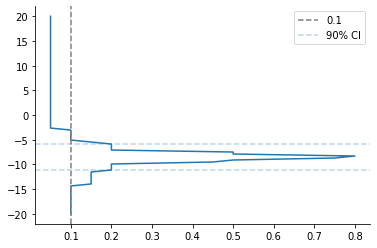

In [60]:
plt.plot(p_values.pvalue, p_values.null)

plt.axvline(x=0.1, linestyle='--', color='gray', label='0.1')
plt.axhline(y=confidence_interval_from_p_values(p_values)['80_ci_lower'].values, linestyle='--', alpha=0.3, label='90% CI')
plt.axhline(y=confidence_interval_from_p_values(p_values)['80_ci_upper'].values, linestyle='--', alpha=0.3)
plt.legend()
sns.despine()

In [69]:
# compute the confidence interval for each periods
nulls = np.linspace(-60, 20, 100)

ci = pd.DataFrame()
# compute point-wise confidence interval for each year
for year in range(1989, 2001):
    p_value_di = pvalue_grid(target_year=year, nulls=nulls, q=2)
    p_values = pd.DataFrame({"null": [i for i in p_value_di],
                         "pvalue": [p_value_di[i] for i in p_value_di]})
    ci = pd.concat([ci, confidence_interval_from_p_values(p_values, alpha=0.12)], axis=0)

In [70]:
ci.index = np.arange(1989, 2001)
ci

,88_ci_lower,88_ci_upper
1989,-13.939394,-5.858586
1990,-14.747475,-5.858586
1991,-17.979798,-7.474747
1992,-18.787879,-8.282828
1993,-22.828283,-12.323232
1994,-26.868687,-17.171717
1995,-27.676768,-17.979798
1996,-29.292929,-18.787879
1997,-31.717172,-21.212121
1998,-28.484848,-17.979798


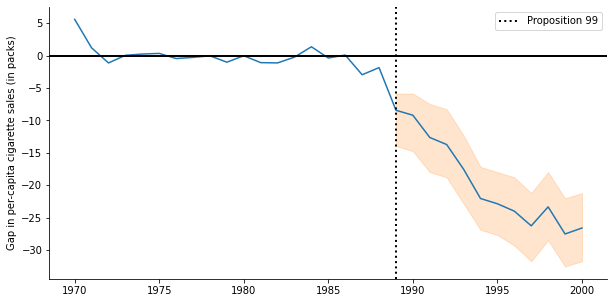

In [71]:
plt.figure(figsize=(10,5))
plt.plot(dat.year, dat.residual)
plt.fill_between(ci.index, ci["88_ci_lower"], ci["88_ci_upper"], alpha=0.2,  color="C1")
plt.axhline(y=0, lw=2, color="Black")
plt.axvline(x=1989, linestyle=":", color="Black", lw=2, label="Proposition 99")
plt.legend()
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
sns.despine()